<a href="https://colab.research.google.com/github/ReemJbily/SRCNN-google-colaboratory-tutorial/blob/main/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential #for creating the model
from tensorflow.keras.layers import Input, Conv2D #for adding layers to the model
from tensorflow.keras.optimizers import Adam #the optimizer of the model
from tensorflow.keras.callbacks import ModelCheckpoint #checkpoints are used to save the weights and bias of a network at a specific point
import cv2 #for image processing
import numpy as np #for matrices manipulation
import matplotlib.pyplot as plt #for displaying images
import math #for math operations
import os #for file manipulation
import h5py #for dealing with h5 file

In [7]:
!python --version

Python 3.7.12


In [ ]:
from zipfile import ZipFile
def extract(path):
  with ZipFile(path,'r') as zip:
      zip.extractall()
import os
def make_dir(dir):
  if not os.path.exists(dir):
    os.mkdir(dir)
extract('/content/drive/My Drive/train/291.zip')  
extract('/content/drive/My Drive/train/test_data.zip') 

In [ ]:
DATA_PATH = "./291"
TEST_PATH = "./Set14"
BLOCK_STEP = 16
BLOCK_SIZE = 32
Random_Crop = 30
Patch_size = 32
label_size = 20
conv_side = 6
scale =2

In [ ]:
def prepare_data(_path):
  '''for building the test images'''
  #get the names of all the directory of the images in the _path directory
  names = os.listdir(_path)
  #sort the names in an asceding order
  names = sorted(names)
  #get the number of images in the _path directory
  nums = names.__len__()
  #define two arrays to hold all the data images and their corresponding label images
  data = np.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=np.double)
  label = np.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=np.double)

  for i in range(nums):
    #get th path of every singel image
    name = os.path.join(_path , names[i])
    #read the image that is a highy resolution image
    hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
    #get the shape of the highy resolution image
    shape = hr_img.shape
    #convert the hr image to be ycrcb
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    #get the y(luma component)only to reduce the size of the input
    #the y is brightness of an image and it is important for human sight
    hr_img = hr_img[:, :, 0]
    #two resize operation to produce training data and labels (the low resolution image)
    lr_img = cv2.resize(hr_img, (shape[1] // scale, shape[0] // scale))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))
    #produce Random_Crop random coordinate to crop training img
    Points_x = np.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)
    Points_y = np.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)
    for j in range(Random_Crop):
      lr_patch = lr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]
      hr_patch = hr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]
      lr_patch = lr_patch.astype(float) / 255.
      hr_patch = hr_patch.astype(float) / 255.
      data[i * Random_Crop + j, 0, :, :] = lr_patch
      label[i * Random_Crop + j, 0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]
  return data, label

In [ ]:
#prepare the input data
def prepare_crop_data(_path):
  #get the names of all the directory of the images in the _path directory
  names = os.listdir(_path)
  #sort the names in an asceding order
  names = sorted(names)
  #get the number of images in the _path directory
  nums = names.__len__()
  #initialize lists
  data = []
  label = []
  for i in range(nums):
    #get th path of every singel image      
    name = os.path.join(_path , names[i])
    #read the image that is a highy resolution image
    hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
    #convert the hr image to be ycrcb
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    #get the y(luma component)only to reduce the size of the input
    #the y is brightness of an image and it is important for human sight
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape

    #two resize operation to produce training data and labels
    lr_img2 = cv2.resize(hr_img, (shape[1] // 2, shape[0] // 2))
    lr_img2 = cv2.resize(lr_img2, (shape[1], shape[0]))
    
    #get th convenient number of iterations over the width and height of the hr image  
    width_num = (shape[0] - (BLOCK_SIZE - BLOCK_STEP) * 2) // BLOCK_STEP
    height_num = (shape[1] - (BLOCK_SIZE - BLOCK_STEP) * 2) //BLOCK_STEP
    for k in range(width_num):
      for j in range(height_num):
        x = k * BLOCK_STEP
        y = j * BLOCK_STEP
        #crop a part of the hr image
        hr_patch = hr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
        #crop a part of the lr image
        lr_patch2 = lr_img2[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
        #convert the type of the array to float then normalize it by dividing over 255
        lr_patch2 = lr_patch2.astype(float) / 255.
        hr_patch = hr_patch.astype(float) / 255.

        lr2 = np.zeros((1, Patch_size, Patch_size), dtype=np.double)
        hr = np.zeros((1, label_size, label_size), dtype=np.double)
        lr2[0, :, :] = lr_patch2
        hr[0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

        data.append(lr2)
        label.append(hr)

    data = np.array(data, dtype=float)
    label = np.array(label, dtype=float)
    return data, label

In [ ]:
def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(np.float32)
    y = labels.astype(np.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)        


def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = np.array(hf.get('data'))
        label = np.array(hf.get('label'))
        train_data = np.transpose(data, (0, 2, 3, 1))
        train_label = np.transpose(label, (0, 2, 3, 1))
        return train_data, train_label

if __name__ == "__main__":
    data, label = prepare_crop_data(DATA_PATH)
    print(data.shape)
    write_hdf5(data, label, "crop_train.h5")
    data, label = prepare_data(TEST_PATH)
    write_hdf5(data, label, "test.h5")

(115701, 1, 32, 32)


The following function is used to build the model which is a sequential model that cosists of three convolution layers each of which has an **N** number of filters with size of (fXf) dimensions with padding p and stride s and a relu activation function and different padding methods.
then the model is compiled with Adam optimizer and a learning rate of 0.0001 and a mean square error as a loss function.
The output of each layer:
if the input was of size (wXh) which are usually the same that is w=h, then the output would be 
([(w-f+2p)/s]+1,[(h-f+2p)/s]+1). 

In [ ]:
#building the model
def SRCNN():    
    SRCNN = Sequential()
    SRCNN.add(Conv2D(128,(9,9),activation='relu', padding='valid',use_bias=True,
                     input_shape=(32, 32, 1)))
    SRCNN.add(Conv2D(64,(3,3),activation='relu', padding='same', use_bias=True))    
    SRCNN.add(Conv2D(1,(5,5),activation='linear', padding='valid', use_bias=True))
    adam = Adam(learning_rate=0.0001)

    SRCNN.compile(optimizer=adam, 
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'])

    return SRCNN



In [ ]:
model=SRCNN()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 128)       10496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        73792     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 1)         1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#training the model
def train():
    srcnn_model = SRCNN()    
    data, label = read_training_data("./crop_train.h5")
    val_data, val_label = read_training_data("./test.h5")

    checkpoint = ModelCheckpoint("SRCNN.h5", monitor='val_loss', verbose=1, save_best_only=True,
                                 save_weights_only=False, mode='min')
    callbacks_list = [checkpoint]
    #start the training
    srcnn_model.fit(data, label, batch_size=128, 
                    validation_data=(val_data, val_label),
                    callbacks=callbacks_list, 
                    shuffle=True, epochs=100, verbose=1)


if __name__ == "__main__":
    train()

Epoch 1/100
904/904 [==============================] - 23s 25ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0016 - val_mean_squared_error: 0.0016

Epoch 00001: val_loss improved from inf to 0.00162, saving model to SRCNN.h5
Epoch 2/100
904/904 [==============================] - 22s 24ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0015 - val_mean_squared_error: 0.0015

Epoch 00002: val_loss improved from 0.00162 to 0.00155, saving model to SRCNN.h5
Epoch 3/100
904/904 [==============================] - 22s 24ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0015 - val_mean_squared_error: 0.0015

Epoch 00003: val_loss improved from 0.00155 to 0.00153, saving model to SRCNN.h5
Epoch 4/100
904/904 [==============================] - 22s 24ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0015 - val_mean_squared_error: 0.0015

Epoch 00004: val_loss improved from 0.00153 to 0.00151, saving model to SRCNN.h5
Epoch 5/100
904/

In [ ]:
#building the metrices for measuring the output closeness to the desierd output
def psnr(target, ref):
    target_data = np.array(target, dtype=float)
    ref_data = np.array(ref, dtype=float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

In [ ]:
def predict(path,input_pth,output_pth,model_pth):
  #load the architecture of the model
  srcnn_model = SRCNN()
  #load the saved weights
  srcnn_model.load_weights(model_pth)
  
  scale=2
  IMG_NAME = path
  INPUT_NAME =input_pth
  OUTPUT_NAME =output_pth
    
  img = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  shape = img.shape

  Y_img = cv2.resize(img[:, :, 0], (shape[1] // scale, shape[0] // scale), cv2.INTER_CUBIC)
  Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
  img[:, :, 0] = Y_img
  img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
  #save the input (low resolution) image
  cv2.imwrite(INPUT_NAME, img)

  Y = np.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
  Y[0, :, :, 0] = Y_img.astype(float) / 255.
  pre = srcnn_model.predict(Y, batch_size=1) * 255.
  pre[pre[:] > 255] = 255
  pre[pre[:] < 0] = 0
  pre = pre.astype(np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
  img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
  #save the output (super resolution) image of the model
  cv2.imwrite(OUTPUT_NAME, img)

  # psnr calculation:
  im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
  im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
  im2 = cv2.imread(INPUT_NAME, cv2.IMREAD_COLOR)
  im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
  im3 = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)
  im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]

  print("bicubic:")
  print(cv2.PSNR(im1, im2))
  print("SRCNN:")
  print(cv2.PSNR(im1, im3))

In [ ]:
#call functions for testing
path="/content/Set5/butterfly_GT.bmp"
input_pth="./input.jpg"
output_pth="./output.jpg"
predict(path,input_pth,output_pth,model_pth="/content/SRCNN.h5")

bicubic:
24.696589313104266
SRCNN:
30.35902456120542


In [ ]:
def show_n_columns(y,*args):
  f,axarr=plt.subplots(1,y)
  for j in range(y):
    axarr[j].imshow(args[j],cmap='gray')

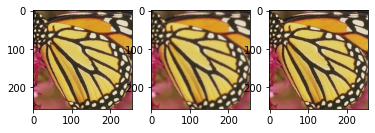

In [ ]:
original_image=cv2.cvtColor(cv2.imread('/content/Set5/butterfly_GT.bmp'),cv2.COLOR_BGR2RGB)
low_resolution_image=cv2.cvtColor(cv2.imread('/content/input.jpg'),cv2.COLOR_BGR2RGB)
super_resolution_image=cv2.cvtColor(cv2.imread('/content/output.jpg'),cv2.COLOR_BGR2RGB)
show_n_columns(3,original_image,low_resolution_image,super_resolution_image)